In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 2
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 0,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 5
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon. I was raised by my grandmother, but the world didn't change until I was ten years old. In the early 20th century, when the first dragon was born, I was a girl, and it was my dream to become a dragon. When I was five, I was the dragon's father. At thirteen, I was a child. I had a lot of trouble with a bad heart, but I knew I was right.

I'd come to this country in the early 1980s, and when I arrived in New York, my mother had told me I'd never get back


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    break

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
# Clean up
del has_seen_rp
# dataset['model_seeder'].stop_worker()
# del dataset

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors


<d><scn>black<msg>n "It was only then, when our race had become so dependent on technology, that we were immeasurably vulnerable against this kind of disaster."<|endoftext|><d><scn>facin2<msg>Ry "Consider this a warning. You should proceed carefully, for your own good."<|endoftext|><d><scn>beach<msg>Ad "What a crazy coincidence."<|endoftext|><d><scn>np2x<msg>Ad "Goodbye, [player_name]."<|endoftext|><d><scn>park3<msg>Br "
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors


 you leaving?"<|endoftext|><d><scn>black<msg>Lo "It's a bit sad not to have them as a natural letter opener anymore, though."<|endoftext|><p><msg>c "I'm not surprised. They can set the mood for a romantic evening."<|endoftext|><p><msg>c "Fight Lorem"<d><scn>black<msg>m "Lorem dodges my attack and comes rushing towards me"<|endoftext|><p><msg>c "No, thanks. It's all yours."<|endoftext|><p><msg>c "It's a shame. I bet your stunts would
 have been amazing to see."<|endoftext|><d><scn>emeraroom<msg>Em "That's good to know."<|endoftext|><d><scn>park2<msg>Ry "I guess she did try to talk to me, but it was only because she wanted something."<|endoftext|><d><scn>o2<msg>Sb "Yes. The whole building is underground, and we've determined that there is a rather large pocket of water surrounding it. Any kind of disturbance could endanger everything and everyone inside."<|endoftext|><p><msg>c "Before we get to that, you haven't even


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
2,3.802700
4,3.573800
6,3.883100
8,3.888000
10,3.619900
12,3.521200
14,3.193200
16,3.150600
18,2.939800
20,2.949600


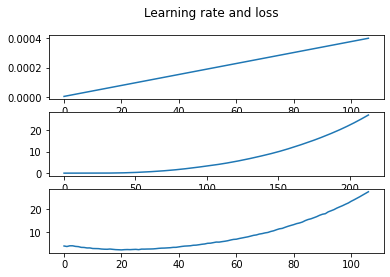

In [9]:
fig, axs = plt.subplots(3)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['model_closeness_loss'])
axs[2].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

# Conversion to ONNX
ONNX is a different format for running machine learning models. The ONNX format is much faster on CPU, sometimes 5 times as fast as PyTorch!

While the EAWSW model is designed to be small, accurate and accessible, for some people it's still too much to run...

Hosting the model as a free service for players is an option. An ONNX version of the model allows us to host the model on CPU yet have faster response times! Given that the model is made in a time with chip shortage, running on hardware I already have inside a server is efficient, scalable and cheaper.

An important note is that ONNX doesn't execute logic by itself, and you have to do that yourself, `onnx_model_manager.py` intends to deal with this for us.

In [11]:
saved_model_onnx_path = os.path.join("models", "awsw_onnx")
if not os.path.exists(os.path.join(saved_model_path, "special_tokens_map.json")):
    print("Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!")
    !cd $saved_model_path && git clone https://huggingface.co/EleutherAI/gpt-neo-125M
    !cp -n $saved_model_path/gpt-neo-125M/* $saved_model_path
    !rm -rf $saved_model_path/gpt-neo-125M
if not os.path.exists(os.path.join(saved_model_onnx_path, "model.onnx")):
    !python3 -m transformers.onnx --model=$saved_model_path --feature=causal-lm-with-past $saved_model_onnx_path

Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!
Cloning into 'gpt-neo-125M'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 38 (delta 16), reused 0 (delta 0)
Unpacking objects: 100% (38/38), 542.60 KiB | 901.00 KiB/s, done.
Using framework PyTorch: 1.10.1+cu113
Overriding 1 configuration item(s)
	- use_cache -> True
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:90: UserWarning: 'enable_onnx_checker' is deprecated and ignored. It will be removed in the next PyTorch release. To proceed despite ONNX checker failures, catch torch.onnx.ONNXCheckerError.
  warnings.warn("'enable_onnx_checker' is deprecated and ignored. It will be removed in "
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:103: UserWarning: `use_external_data_format' is deprecated and ignored. Will be removed in next PyT

In [12]:
def optimize_onnx():
    model_quant = os.path.join(saved_model_onnx_path, "model_quant.onnx")
    if not os.path.exists(model_quant):
        model_fp32 = os.path.join(saved_model_onnx_path, "model.onnx")
        model_opt = os.path.join(saved_model_onnx_path, "model-opt.onnx")
        quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)
        #!rm $model_opt
optimize_onnx()

In [13]:
onnx_model_manager = OnnxModelManager(os.path.join(saved_model_onnx_path, "model.onnx"))

In [14]:
prompt = "In my dreams, I'm a dragon"
for i in range(10):
    print("ONNX:", onnx_model_manager.say_raw(prompt, do_sample=True))
    print("PyTorch:", model_manager.say_raw(prompt, 50, 0.7))
    print('-' * 100)

ONNX: In my dreams, I'm a dragoness who dreams. I see the stars, the sky. I see the creatures that live in my dreams."<|endoftext|>
PyTorch: In my dreams, I'm a dragon. I can see the purity of dragons. They are noble creatures that live in my dreams. I wish I could be that way with them."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragoness who dreams. I see the stars, and the colors that are there in the sky."<|endoftext|>
PyTorch: In my dreams, I'm a dragoness who dreams big."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragoness who dreams. I see the stars, and the dragons. I see the landscape, and the birds singing."<|endoftext|>
PyTorch: In my dreams, I'm a dragoness who knows how to take care of the humans in the world. I even tried to get her to take care of the humans in our world. She on

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [15]:
test_regular_sampler()

In my dreams, I'm a dragon. I can shapeshift into humans, or whatever you want to call it."<|endoftext|>


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [16]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def sample_test(model_manager):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt)
        print(f"Prompt: {prompt}\nReply: {reply}\n\n")
print("Test Pytorch...")
start = time.time()
sample_test(model_manager)
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
sample_test(onnx_model_manager)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
Prompt: How are you?
Reply: park2<msg>Ry "I'm fine. I just..."<p><msg>c "I don't like words."<d><scn>park2<msg>Ry "I don't like words."<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"<p><msg>c "How are you?"<d><sc


Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "I think he's a good art critic."<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."<|endoftext|>


Prompt: Oh my god, Adine. What is this?
Reply: o2<msg>Ad "I don't like them very much. I mean, they're just not as attractive as mine, but they're still pretty girthy."<p><msg>c "I don't like them very much."<d><scn>o2<msg>Ad "I don't like them very much. I mean, they're just not as attractive as mine, but


Prompt: What will we do here?
Reply: o2<msg>Ad "I don't like words."<p><msg>c "I don't like words."<d><scn>o2<msg>Ad "I don't like words."<p><msg>c "I don't like words."<d><scn>o2<msg>Ad "I don't like words."<p><msg>c

# Sampling test

This is gonna be interesting!

In [17]:
print("Test Pytorch...")
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
logging.basicConfig(level=logging.DEBUG)
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = onnx_model_manager.say(past, prompt, do_sample = True)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "I'm fine. I just..."<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"<p><msg>c "How are you?"<d><scn>park2<msg>Ry "I'm fine. I just..."<p><msg>c "Hey Remy!"<d><scn>

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "You wouldn't have, but you're doing something right now. Don't take this the wrong way, Reza."<d><scn>park2<msg>Ad "I like that."<p><msg>c "You aren't."<d><scn>park2<msg>Ad "I was with Lorem

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: loremapt<msg>Lo "I was bored."<d><scn>loremapt<msg>Lo "Oh, I forgot about that. Let me try that again."<p><msg>c "I just did."<d><scn>loremapt<msg>Lo "I was bored."<p><msg>c "Oh my god, Adine. What is this

[Test 1] -> Prompt: What will we do here?
Reply: loremapt<msg>Ip "If humans are the real answer, then what other theories of humans do we have?"<p><msg>c "I don't know."<d><scn>loremapt<msg>Ip "You don't know what you are talking about."<

# RP test
Testing out the injected roleplay actions

In [18]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')

Visit Lorem -> loremapt<msg>Lo "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
Meet with Lorem -> loremapt<msg>Lo "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
Fight Maverick -> black<msg>m "A few minutes later, we arrived at the outskirts of town. My first instinct was to run away, but as I did so, I heard voices."<|endoftext|>
Fight Adine -> adineapt<msg>Ad "Oh, come on. Let me do that for you."<|endoftext|>
Attack Adine -> adineapt<msg>Ad "What's that?"<p><msg>c "A few."<d><scn>adineapt<msg>Ad "Oh, [player_name], I didn't expect you to arrive so early."<p><msg>c "A few."<d><scn>adineapt<msg>Ad "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
